# Simple FEM for one dimensional heat transfer problem

The problem for $T(t,x)$ is stated as
$$
\frac{\partial T}{\partial t} - \alpha \Delta T = 0 \quad \text{for} \quad x \in [0,L] , t \in [0, Z]
$$
with a constant heat conductivity $\alpha$ subject to the boundary condition
$$
T(t, x=0) = 1
$$
and the initial condition
$$
T(t=0, x) = \cos(2\pi x)
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skfem as fem
from skfem.helpers import dot, grad
from skfem.visuals.matplotlib import draw, plot

from global_constants import L, Z, alpha

# Mesh
N = 10
mesh = fem.MeshLine(np.linspace(0, L, N))
mesh = mesh.with_boundaries({"left": lambda x: x == 0})
print(mesh)

<skfem MeshLine1 object>
  Number of elements: 9
  Number of vertices: 10
  Number of nodes: 10
  Named boundaries [# facets]: left [1], right [1]


## Create the FEM basis

In [2]:
# Define second order line elements
element = fem.ElementLineP2()

# Basis
basis = fem.Basis(mesh, element)

# Location of vertices
x = basis.doflocs[0]

# Problem formulation
The weak form of the equation to be solved is 

$$ 
 \int_\Omega \frac{\partial T}{\partial t} v dV  + \int_\Omega \alpha \nabla T \cdot \nabla v dV = 0.
$$

In [3]:
@fem.BilinearForm
def a(T, v, _):
    return alpha * dot(grad(T), grad(v))


@fem.BilinearForm
def c(T_dot, v, _):
    return T_dot * v


# Initial conditions
T = np.cos(2.0 * np.pi * x)

## Assemble
Assemble the system to a linear algebra equation for the solution vector $T$

$$
 \bm{C} \dot{T} - \bm{A} T = 0
$$

In [4]:
# Assemble matrices
A = fem.asm(a, basis)
C = fem.asm(c, basis)

## Integrate in time 
Crank-Nicholson time discretization yields 

$$ 
 [\bm{C} + \frac{1}{2} \Delta t \bm{A}] T^{n+1} = \bm{C} T^n - \frac{1}{2}  \Delta t \bm{A} T^n
$$

for the unknown vector $T^{n+1}$. This can be reformulated to 
$$ 
 \bm{K} T^{n+1} = \bm{b}
$$

with $\bm{K} = \bm{C} + \frac{1}{2} \Delta t \bm{A}$ and $\bm{b} = \bm{C} T^n - \frac{1}{2}  \Delta t \bm{A} T^n $.

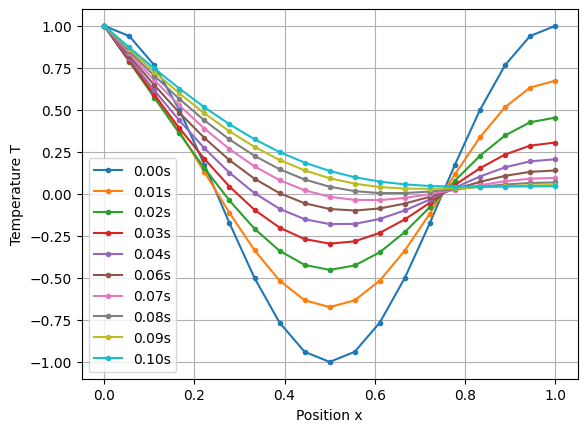

In [5]:
dt = 1e-4
t = 0
results = [T]
for i in range(1, int(Z / dt)):
    # Remove prescribed DoFs
    K = C + 0.5 * dt * A
    b = C @ T - 0.5 * dt * A @ T
    D = basis.get_dofs({"left"})
    T = fem.solve(*fem.condense(K, b, D=D, x=T))
    if i % 100 == 0:
        results.append(T)

sorted = np.argsort(x)
for res in results:
    plt.plot(x[sorted], res[sorted], ".-")

plt.legend([f"{t:.2f}s" for t in np.linspace(0, Z, 10)])
plt.xlabel("Position x")
plt.ylabel("Temperature T")
plt.grid()